In [2]:
import os
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf


env = "local"

In [2]:
if env == "local":
    os.chdir("/Users/samuel/Documents/GitHub/QB-GPT/")
else:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/MyDrive/NFL_Challenge/NFL-GPT/NFL data")

In [3]:
os.listdir()

['data_models',
 '.DS_Store',
 'app',
 'LICENSE',
 'models',
 'README.md',
 '.gitignore',
 'L2_plot.png',
 '.gitattributes',
 'indexv2',
 'data_preprocessing',
 'index',
 '.git',
 'notebooks']

In [4]:
testing_data = tf.data.Dataset.load("data_models/QBGPT/test_tokens_NFL_GPT_v2")

In [5]:
moves_index = pl.read_parquet("indexv2/moves_index.parquet")
position_index = pl.read_parquet("indexv2/positions_index.parquet")
starts_index = pl.read_parquet("indexv2/starts_index.parquet")
scrim_index = pl.read_parquet("indexv2/scrimmage_index.parquet")
playtype_index = pl.read_parquet("indexv2/plays_index.parquet")
time_index = pl.read_parquet("indexv2/time_index.parquet")

In [6]:
class tokenizer:
    def __init__(self, 
                 moves_index : str,
                 play_index : str,
                 positions_index  : str,
                 scrimmage_index : str,
                 starts_index : str,
                 time_index : str,
                 window_size : int):
        self.window = window_size
        
        moves_index = pl.read_parquet(moves_index)
        self.moves_index = self.convert_index_to_dict(moves_index)
        
        play_index = pl.read_parquet(play_index)
        self.play_index= self.convert_index_to_dict(play_index)
        
        positions_index = pl.read_parquet(positions_index)
        self.positions_index = self.convert_index_to_dict(positions_index)
        
        scrimmage_index = pl.read_parquet(scrimmage_index)
        self.scrimmage_index = self.convert_index_to_dict(scrimmage_index)
        
        starts_index = pl.read_parquet(starts_index)
        self.starts_index = self.convert_index_to_dict(starts_index)
        
        time_index = pl.read_parquet(time_index)
        self.time_index = self.convert_index_to_dict(time_index)
        
        self.offdef_index = {0 : ["Def"],
                             1 : ["Off"]}
        
        self.index = {"input_ids" : self.moves_index,
                      "PlayType" : self.play_index,
                      "position_ids" : self.positions_index,
                      "scrim_ids" : self.scrimmage_index,
                      "start_ids" : self.starts_index,
                      "pos_ids" : self.time_index,
                      "OffDef" : self.offdef_index}
    
    def convert_index_to_dict(self, df : pl.DataFrame):
    
        ID_col = [v for v in df.columns if "ID" in v]
        assert len(ID_col) == 1
        new_id_name = ["ID"]

        val_cols = [v for v in df.columns if v not in ID_col+["Cat"]]
        new_val_name = ["Val_"+str(i) for i in range(1, len(val_cols)+1)]

        past_names = ID_col + val_cols
        new_names = new_id_name+new_val_name

        renaming = {past_names[i]: new_names[i] for i in range(len(new_names))}

        d = (df.
                drop("Cat").
                rename(renaming).
                select(new_names).
                to_dict(as_series=False))

        final_d = {d["ID"][i] : [d[k][i] for k in new_val_name] for i in range(len(d["ID"]))}

        return final_d
    
    def base_decode(self,
                    inputs : list,
                    index : dict,
                    first : bool):
        if first == True:
            return [index[v][0] if v in index.keys() else "[PAD]" for v in inputs]
        else:
            return [index[v] if v in index.keys() else "[PAD]" for v in inputs]
        
    def decode(self,
               inputs : list,
               type : str):
        if type in ["input_ids", "start_ids"]:
            return self.base_decode(inputs, index = self.index[type], first=False)
        else:
            return self.base_decode(inputs, index = self.index[type], first=True)

    def find_id_by_values(self, 
                          input_dict : dict, 
                          target_list : list):
        
        for key, values in input_dict.items():
            if set(target_list) == set(values):
                return key
        
    def base_encode(self,
                inputs : list,
                index : dict):
        return [self.find_id_by_values(index, [v]) for v in inputs]
    
    def encode(self,
               inputs : list,
               type : str):
        return self.base_encode(inputs, index = self.index[type])
    
    def decode_sequence(self,
                        input : dict):
        return {k : self.decode(v, k) if k not in ["side_ids", "token_type_ids", "labels", "attention_mask", "ids"] else v for k,v in input.items()}
    
    def encode_sequence(self,
                        input : dict):
        return {k : self.encode(v, k) if k not in ["side_ids", "token_type_ids", "labels", "attention_mask", "ids"] else v for k,v in input.items()}
    
    def truncate_to_time_t(self,
                           input : dict,
                           t : int):
        to_keep = [i < t for i in input["pos_ids"]]
        return {k: [v[i] for i in range(len(v)) if to_keep[i] == True] for k,v in input.items()}
    
    def resize_window(self,
                      input : dict,
                      pos_id):
        out = input.copy()
        out["attention_mask"] = [0 if out["pos_ids"][p] <pos_id else 1 for p in range(len(out["pos_ids"]))]
        return out
    
    def prepare_for_call(self, 
                         input : dict):
        #resize_limit = max([v for v in np.array(input["pos_ids"]).flatten() if v != 51]) - self.window
        #if resize_limit > 0:
            #input = self.resize_window(input, resize_limit)
        
        done = {k : tf.constant(v) for k,v in input.items()}
        if len(done["pos_ids"].shape) == 1:
            done = {k : tf.expand_dims(v, axis=0) for k,v in input.items()}
        return done        

In [7]:
qb_tok = tokenizer(moves_index="indexv2/moves_index.parquet",
                   play_index="indexv2/plays_index.parquet",
                   positions_index="indexv2/positions_index.parquet",
                   scrimmage_index="indexv2/scrimmage_index.parquet",
                   starts_index="indexv2/starts_index.parquet",
                   time_index="indexv2/time_index.parquet",
                   window_size=20)

In [8]:
from models.modeling.QBGPT.models import QBGPT, LargeQBGPT

moves_to_pred = 11170
input_size = 11172
starts_size = 1954
scrimmage_size = 100
positions_id = 29

temp_ids = 52
off_def_size = 2
token_type_size = 3
play_type_size = 9

model_medium = QBGPT(input_vocab_size = input_size,
                    positional_vocab_size = temp_ids,
                    position_vocab_size=positions_id,
                    start_vocab_size=starts_size,
                    scrimmage_vocab_size=scrimmage_size,
                    offdef_vocab_size = off_def_size,
                    type_vocab_size = token_type_size,
                    playtype_vocab_size = play_type_size,
                    embedding_dim = 256,
                    hidden_dim = 256,
                    to_pred_size = moves_to_pred)

model_medium.load_weights("models/modeling/QBGPT/weights/model_mediumv2/QBGPT")

In [9]:
class generator:
    def __init__(self,
                 model,
                 tokenizer):
        
        self.QBGPT = model
        self.tokenizer = tokenizer
        
    def cut(self, l, ref):
        splitted = []
        cutted = []
        for i in range(len(l)):
            if ref[i] == True:
                cutted.append(l[i])
            else:
                splitted.append(cutted)
                cutted = []
                cutted.append(l[i])     
            if i == len(l)-1:
                splitted.append(cutted) 
        return splitted
        
    def get_last_preds(self,
                       logits,
                       input : dict):
        
        to_keep = [i == max(input["pos_ids"]) for i in input["pos_ids"]]
        return np.array([logits[i] for i in range(len(logits)) if to_keep[i] == True])
        
    def get_logits(self, 
                   input : dict):
        x = self.tokenizer.prepare_for_call(input)
        return self.QBGPT(x)
    
    def convert_to_preds(self,
                         logits):
        preds = tf.math.softmax(logits=logits, axis = 2)
        preds = tf.argmax(preds, axis = 2).numpy()
        preds = tf.squeeze(preds, axis=0)
        return preds
    
    def generate(self,
                 input : dict):
        logits = self.get_logits(input)
        preds = self.convert_to_preds(logits)
        return self.get_last_preds(preds, input)
    
    def slice_inputs(self,
                     input : dict):
        flags = [True] + [input["pos_ids"][i+1] > input["pos_ids"][i] for i in range(len(input["pos_ids"])-1)]
        cutted_inputs = {k : self.cut(v, flags) for k,v in input.items()}
        return cutted_inputs
    
    def continue_by_token(self, 
                         arr,
                         token :str):
        if token == "input_ids":
            return arr
        if token == "pos_ids":
            insert = max(arr)+1
            return np.concatenate([arr, np.array([insert])])
        elif token == "token_type_ids":
            return  np.concatenate([arr, np.array([1])])
        else:
            return  np.concatenate([arr, [arr[-1]]])
            
        
    def append_prediction(self,
                           arr,
                           pred):
        return np.concatenate([arr, [pred]])
    
    def append_predictions(self,
                           d : dict,
                           preds):
        new = d.copy()
        new["input_ids"] = [self.append_prediction(new["input_ids"][i], preds[i]) for i in range(len(preds))]
        return new
                
    def merge_cuts(self, 
                   input : dict):
        return {k : np.concatenate(v) for k,v in input.items()}
        
    def update_inputs(self,
                      input,
                      preds):
        sliced = self.slice_inputs(input)
        appended = self.append_predictions(sliced, preds)
        continued = {k : [self.continue_by_token(e, k) for e in v] for k,v in appended.items()}
        merged = self.merge_cuts(continued)
        return merged
    
    def generate_sequence(self,
                          input,
                          t):
        new_input = input.copy()
        for i in range(t):
            print(i)
            generated = self.generate(new_input)
            new_input = self.update_inputs(new_input, generated)
        return new_input
    
    def remove_pad(self,
                   seq):
        df = pd.DataFrame(seq)
        filtered = df[df["input_ids"] != "[PAD]"].reset_index(drop=True)
        filtered = filtered[filtered["pos_ids"] != "[PAD]"].reset_index(drop=True)
        return filtered.to_dict(orient = "list")
    
    def _compute_true_sequence(self,
                          scrimmage_line,
                          start : list,
                          moves : list):
        scrimmage = np.array([scrimmage_line, 26.5])
        updated_moves = np.array([np.array(start) + np.array(v) for v in moves])
        appended = np.concatenate([[start], updated_moves])
        final = appended + scrimmage
        return final
    
    def compute_true_sequence(self,
                              scrims,
                              starts,
                              moves):
        return self._compute_true_sequence(np.unique(scrims)[0], np.unique(starts), moves)
    
    def _resize_variable(self,
                         x, 
                         ref: str):
        if ref in ["pos_ids", "token_type_ids"]:
            return np.concatenate([[0], x])
        elif ref in ["input_ids", "start_ids"]:
            return np.vstack([np.unique(x), x])
        else:
            return np.concatenate([np.unique(x), x])
    
    def prepare_for_plot(self, 
                         seq):
        sequence = seq.copy()
        sequence = self.remove_pad(sequence)
        cutted = self.slice_inputs(sequence)
        moves_updated = [self.compute_true_sequence(cutted["scrim_ids"][i], cutted["start_ids"][i], cutted["input_ids"][i]) for i in range(len(cutted["input_ids"]))]
        cutted["input_ids"] = moves_updated
        cutted = {k : [self._resize_variable(e, k) if k != "input_ids" else e for e in v] for k,v in cutted.items()}
        cutted["ids"] = [[i for e in range(len(cutted["input_ids"][i]))] for i in range(len(cutted["input_ids"]))]
        merged = self.merge_cuts(cutted)
        converted = self.convert_list(merged)
        return {k:v for k,v in converted.items() if k != "labels"}
    
    def insert_ids(self,
                   input):
        
        cutted = self.slice_inputs(input)
        cutted["ids"] = [[i for e in range(len(cutted["input_ids"][i]))] for i in range(len(cutted["input_ids"]))]
        merged = self.merge_cuts(cutted)
        return merged
    
    
    def convert_list(self,
                     d):
        new_df = d.copy()
        new_df["start_ids_x"] = [v[0] for v in new_df["start_ids"]]
        new_df["start_ids_y"] = [v[1] for v in new_df["start_ids"]]
        new_df["input_ids_x"] = [v[0] for v in new_df["input_ids"]]
        new_df["input_ids_y"] = [v[1] for v in new_df["input_ids"]]
        return {k : v for k,v in new_df.items() if k not in ["start_ids", "input_ids"]}

In [10]:
gen_test = generator(model=model_medium,
                     tokenizer=qb_tok)

In [11]:
essai = list(testing_data)
essai = [v[0] for v in essai if v[0]["pos_ids"].numpy()[0] == 0]
essai = [v for v in essai if np.unique(v["PlayType"])[0] in [4, 7]]

In [12]:
essai_l = {k : v.numpy() for k,v in essai[44].items()}

In [13]:
true = essai_l.copy()
true["input_ids"] = true["labels"]
true = {k:v for k,v in true.items() if k != "labels"}

In [18]:
trial = qb_tok.prepare_for_call(essai[44])
embed_trial = model_medium.Encoder.Embedding(trial)
norm_trial = model_medium.Encoder.Attention1.NormIn(embed_trial)
key_trial = model_medium.Encoder.Attention1.Key(norm_trial)
keys_trial = model_medium.Encoder.Attention1.transpose_for_scores(key_trial, 1)
value_trial = model_medium.Encoder.Attention1.Value(norm_trial)
values_trial = model_medium.Encoder.Attention1.transpose_for_scores(value_trial, 1)
query_trial = model_medium.Encoder.Attention1.Query(norm_trial)
queries_trial = model_medium.Encoder.Attention1.transpose_for_scores(query_trial, 1)

attention_weights_trial = model_medium.Encoder.Attention1.compute_attention_weigths(queries_trial, keys_trial, trial["pos_ids"], trial["attention_mask"])
attention_scores_trial = tf.matmul(attention_weights_trial, values_trial)
#attention_scores_trial = tf.transpose(attention_scores, perm=[0, 2, 1, 3])
#attention_scores_trial = tf.reshape(tensor=attention_scores, shape=(batch_size, -1, self.total_dim))


trial_d = qb_tok.truncate_to_time_t(essai_l, 3)
compare = qb_tok.prepare_for_call(trial_d)
embed_compare = model_medium.Encoder.Embedding(compare)
norm_compare = model_medium.Encoder.Attention1.NormIn(embed_compare)
key_compare = model_medium.Encoder.Attention1.Key(norm_compare)
keys_compare = model_medium.Encoder.Attention1.transpose_for_scores(key_compare, 1)
value_compare = model_medium.Encoder.Attention1.Value(norm_compare)
values_compare = model_medium.Encoder.Attention1.transpose_for_scores(value_compare, 1)
query_compare = model_medium.Encoder.Attention1.Query(norm_compare)
queries_compare = model_medium.Encoder.Attention1.transpose_for_scores(query_compare, 1)

attention_weights_compare = model_medium.Encoder.Attention1.compute_attention_weigths(queries_compare, keys_compare, compare["pos_ids"], compare["attention_mask"])
attention_scores_compare = tf.matmul(attention_weights_compare, values_compare)
#attention_scores_compare = tf.transpose(attention_scores, perm=[0, 2, 1, 3])
#attention_scores_compare = tf.reshape(tensor=attention_scores, shape=(batch_size, -1, self.total_dim))

In [3]:

def causal_mask(batch_size, sequence_length):
    """
    Create a causal (triangular) mask for masked self-attention.
    
    Args:
    - batch_size: Number of sequences in the batch.
    - sequence_length: Length of each sequence.
    
    Returns:
    - A 3D tensor of shape (batch_size, sequence_length, sequence_length).
    """
    mask = 1 - tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)
    mask = tf.reshape(mask, (1, sequence_length, sequence_length))
    return tf.tile(mask, [batch_size, 1, 1])

# Example usage:
batch_size = 4
sequence_length = 10

mask = causal_mask(batch_size, sequence_length)

In [5]:
mask[0]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

<Axes: >

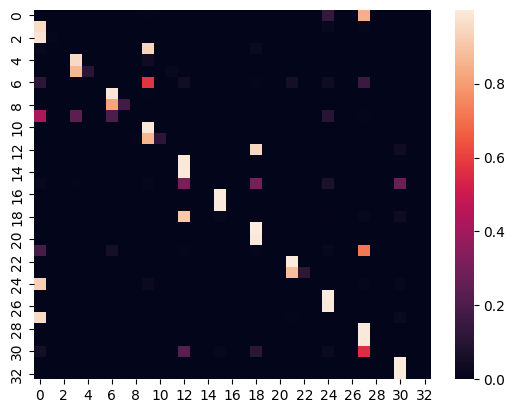

In [19]:
import seaborn as sns 
sns.heatmap(attention_weights_compare[0][0])

<Axes: >

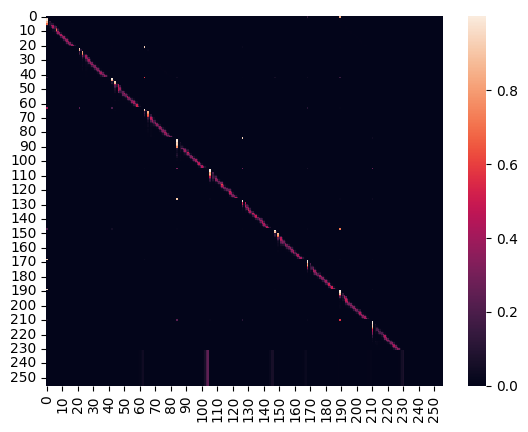

In [17]:
sns.heatmap(attention_weights_trial[0][0])

In [ ]:
0.8*3

In [166]:
attention_scores_compare[0][0][0] == attention_scores_trial[0][0][0]

<tf.Tensor: shape=(256,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fal

In [171]:
attention_weights_compare[0][0][0].numpy()

array([0.0000000e+00, 7.3330819e-05, 5.3432836e-06, 0.0000000e+00,
       1.9512607e-03, 9.1591517e-07, 0.0000000e+00, 1.1502808e-04,
       8.9570594e-06, 0.0000000e+00, 2.4256507e-04, 1.8235667e-05,
       0.0000000e+00, 2.2631642e-04, 1.8378692e-05, 0.0000000e+00,
       3.6986757e-04, 2.9802442e-05, 0.0000000e+00, 2.5173562e-04,
       2.0204765e-05, 0.0000000e+00, 1.9566936e-04, 1.6783088e-05,
       0.0000000e+00, 5.5849989e-04, 3.6837060e-05, 0.0000000e+00,
       4.0582355e-04, 2.7108947e-05, 0.0000000e+00, 9.2032391e-01,
       7.5103439e-02], dtype=float32)

In [164]:
attention_weights_trial[0][0][0].numpy().shape

(256,)

In [32]:
[i == max(compare["pos_ids"]) for i in compare["pos_ids"]]

[<tf.Tensor: shape=(33,), dtype=bool, numpy=
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True])>]

In [42]:
generated["input_ids"]

array([11170,  5587,  5587,  5587,  5587,  5587,  5587,  5587,  5587,
        5587,  5587,  5587,  5587,  5587,  5587,  5587,  5587,  5587,
        5587,  5587,  5587,  5587,  5587,  5587,  5587, 11170,  5587,
        5587,  5587,  5587,  5587,  5587,  5505,  5505,  5420,  5420,
        5337,  5337,  5248,  5248,  5160,  5160,  5073,  5073,  4991,
        4991,  4908,  4908,  4908,  4908, 11170,  5587,  5587,  5587,
        5587,  5587,  5505,  5505,  5420,  5337,  5248,  5160,  5073,
        4991,  4908,  4822,  4822,  4737,  4737,  4737,  4737,  4737,
        4737,  4737,  4737, 11170,  5587,  5587,  5587,  5587,  5587,
        5587,  5505,  5505,  5420,  5420,  5337,  5337,  5248,  5248,
        5160,  5160,  5073,  5073,  4991,  4991,  4908,  4908,  4908,
        4908, 11170,  5587,  5587,  5587,  5587,  5587,  5587,  5587,
        5587,  5587,  5587,  5587,  5587,  5587,  5587,  5587,  5587,
        5587,  5587,  5587,  5587,  5587,  5587,  5587,  5587, 11170,
        5587,  5587,

In [34]:
trial_d = qb_tok.truncate_to_time_t(essai_l, 3)
generated = gen_test.generate_sequence(trial_d, 22)
decoded = gen_test.tokenizer.decode_sequence(generated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [35]:
step1 = gen_test.prepare_for_plot(decoded)
plot = pd.DataFrame(step1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 2

In [61]:
import plotly.express as px

fig = px.line(plot, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="ids",
                 text="position_ids", title="Player Trajectories Over Time",
                 range_x=[0, 140], range_y=[0, 60], # Set X and Y axis ranges
                 line_shape="linear",  # Draw lines connecting points
                 render_mode="svg")  # Render mode for smoother lines

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='lines'))
fig.update_layout(width=800, height=600) 

In [38]:
import plotly.express as px

fig = px.line(plot, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="ids",
                 text="position_ids", title="Player Trajectories Over Time",
                 range_x=[0, 140], range_y=[0, 60], # Set X and Y axis ranges
                 line_shape="linear",  # Draw lines connecting points
                 render_mode="svg")  # Render mode for smoother lines

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='lines'))
fig.update_layout(width=800, height=600) 

In [308]:
fig = px.scatter(essai, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="position_ids",
                 text="position_ids", title="Player Trajectories Over Time")

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='markers+lines'))
fig.update_layout(width=800, height=600) 
fig.update_xaxes(range=[0, 120])
fig.update_yaxes(range=[0, 60])

fig.show()

In [303]:
import plotly.express as px

# Sample data in a Pandas DataFrame (replace this with your actual data)
data = pd.DataFrame({
    "ID": [1, 2, 3, 4, 5, 6, 7, 8],
    "OffDef": ["Off", "Off", "Off", "Off", "Def", "Def", "Def", "Def"],
    "X": [1, 3, 5, 7, 2, 4, 6, 8],
    "Y": [2, 4, 6, 8, 1, 3, 5, 7],
    "positions": ["A", "B", "C", "D", "X", "Y", "Z", "W"],
    "time": [0, 1, 2, 3, 0, 1, 2, 3]  # Replace this with your time data
})

# Create an animated Plotly scatter plot
fig = px.scatter(data, x="X", y="Y", animation_frame="time", color="OffDef", symbol="OffDef",
                 text="positions", title="Player Trajectories Over Time")

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='markers+lines'))

fig.show()